# KEYBERT(SBERT) 를 이용한 Keyword 추출
- 참고 url : https://wikidocs.net/159467
- SBERT은 sentence_transformers 사용
- transfomers, sentence_transformers 다운로드 필요

In [58]:
import pandas as pd
import numpy as np
import itertools

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from konlpy.tag import Okt
okt = Okt()

# 한국어를 포함하고 있는 다국어 SBERT load
model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [2]:
df = pd.read_parquet('after_preprocessing.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361706 entries, 0 to 361705
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   source    361706 non-null  object
 1   content   361706 non-null  object
 2   postdate  361706 non-null  object
 3   platform  361706 non-null  object
dtypes: object(4)
memory usage: 11.0+ MB


# 블로그 글 하나로 Test 해보기

In [3]:
doc = df['content'][0]
doc

'언니 평소 가보고 싶어 하던 휴애리 축제 다녀왔어요 지금 한참 만발 해서 꽃길 걷다 고간 제주 감귤 체험 알차게 즐기고 돌아온 여행 이었습니다 서귀포 남원읍 자리 휴애리 자연생활공원 볼수 있을 유명하답니다 지금 겨울 대표 동백꽃 넓은 부지 활짝 피어 있어 걷는 발길 마다 온통 핑크색 꽃길 걸어 볼수 있고 아기자기 다양한 포토 인생사진 남길수 있는 휴애리 동백 축제 기간 감귤 체험 할수 있는 시기 입니다 휴애리 자연생활공원 제주 서귀포시 남원읍 입장 시간 매일 하절기 입장 마감 입장 마감 휴애리 자연생활공원 주차장 제주특별자치도 서귀포시 남원읍 신례리 휴애리 입장료 성인 단체 단체 단체 유공 경로 우대 도민 자녀 이상 가구 할인 흑돼지 놀자 시간표 하루 흑돼지 공연 볼수 있으니 시간 맞춰 오시 하나 볼거리 있습니다 이건 따로 관람 없고 입장권 포함 입니다 반려견 동반 가능한 미만 소형견 입장 된다고 합니다 입장 하기 위해 선큐알 체크 온도 체크 꼼꼼하게 서서 마치 들어갑니다 시원하게 뿜어내는 분수 작은 연못 시작 해서 위쪽 올라가면 다른 세상 바로 펼쳐질 한라산 배경 동백꽃 함께 감귤 모자 여자 모습 너무도 사랑스럽네요 제주 휴애리 표지 모델 잡지 주인공 될수도 있으니 예쁘게 차려입거나 조금 밝은 입는게 모도 좋습니다 올레길 부터 걸어 볼까 입구 사람 많이 계셨고 연인 삼각대 세워놓고 커플사진 많이 찍는 모습 혼자 셀카 많이 찍는데이 동행 언니 계서 아주 맘껏 찍혀 보았습니다 공원 넓어서 내도 보고 사진 찍어 다니시는게 하나 안놓치고 볼수 있답니다 볼곳 굉장히 많기 때문 그냥 오면 아쉽고 비행기 타고 오는 한번 이맘때 기다려야 하니 실컷 돌아보시 핑크 리가 있었으면 더욱 아름다웠을 글씨 조형물 여기 단체사진 찍음 누가 봐도 제주 있구나 알수 있어 서자랑 사진 찍기 좋더라고요 여성 스럽고 공주 포토 있죠다 축제 즐기느라 조금 한가한 편이 꽃다발 들고 여유 있게 시간 보내 봅니다 걷다 보면 온실 카페 감귤 체험 흑돼지 공연장 먹이 주기 체험 곤충 테마 관등 있는 

In [6]:

tokenized_doc = okt.pos(doc)
stop_word = ['있는','있고','있으니','입니다.','이렇게','있을',]
print(tokenized_doc)
tokenized_list = [w for w,t in tokenized_doc if  t not in ['Verb'] or w in stop_word]


[('언니', 'Noun'), ('평소', 'Noun'), ('가보고', 'Verb'), ('싶어', 'Verb'), ('하던', 'Verb'), ('휴애리', 'Noun'), ('축제', 'Noun'), ('다녀왔어요', 'Verb'), ('지금', 'Noun'), ('한참', 'Noun'), ('만발', 'Noun'), ('해서', 'Verb'), ('꽃길', 'Noun'), ('걷다', 'Verb'), ('고간', 'Noun'), ('제주', 'Noun'), ('감귤', 'Noun'), ('체험', 'Noun'), ('알차게', 'Adjective'), ('즐기고', 'Verb'), ('돌아온', 'Verb'), ('여행', 'Noun'), ('이었습니다', 'Verb'), ('서귀포', 'Noun'), ('남원읍', 'Noun'), ('자리', 'Noun'), ('휴애리', 'Noun'), ('자연생활공원', 'Noun'), ('볼수', 'Verb'), ('있을', 'Adjective'), ('유명하답니다', 'Adjective'), ('지금', 'Noun'), ('겨울', 'Noun'), ('대표', 'Noun'), ('동백꽃', 'Noun'), ('넓은', 'Adjective'), ('부지', 'Noun'), ('활짝', 'Noun'), ('피어', 'Noun'), ('있어', 'Adjective'), ('걷는', 'Verb'), ('발길', 'Noun'), ('마다', 'Noun'), ('온통', 'Noun'), ('핑크색', 'Noun'), ('꽃길', 'Noun'), ('걸어', 'Verb'), ('볼수', 'Verb'), ('있고', 'Adjective'), ('아기자기', 'Noun'), ('다양한', 'Adjective'), ('포토', 'Noun'), ('인생사진', 'Noun'), ('남길수', 'Verb'), ('있는', 'Adjective'), ('휴애리', 'Noun'), ('동백', 'Noun'), ('축제', 'Noun'), 

In [7]:
tok_sentence = ' '.join(tokenized_list)
tok_sentence

'언니 평소 휴애리 축제 지금 한참 만발 꽃길 고간 제주 감귤 체험 알차게 여행 서귀포 남원읍 자리 휴애리 자연생활공원 있을 유명하답니다 지금 겨울 대표 동백꽃 넓은 부지 활짝 피어 있어 발길 마다 온통 핑크색 꽃길 있고 아기자기 다양한 포토 인생사진 있는 휴애리 동백 축제 기간 감귤 체험 있는 시기 입니다 휴애리 자연생활공원 제주 서귀포시 남원읍 입장 시간 매일 하절기 입장 마감 입장 마감 휴애리 자연생활공원 주차장 제주특별자치도 서귀포시 남원읍 신례리 휴애리 입장료 성인 단체 단체 단체 유공 경로 우대 도민 자녀 이상 가구 할인 흑돼지 시간표 하루 흑돼지 공연 있으니 시간 오시 하나 볼거리 있습니다 이건 따로 관람 없고 입장권 포함 입니다 반려견 동반 가능한 미만 소형견 입장 입장 위해 선큐알 체크 온도 체크 꼼꼼하게 서서 마치 시원하게 분수 작은 연못 시작 위쪽 다른 세상 바로 한라산 배경 동백꽃 함께 감귤 모자 여자 모습 너무도 사랑스럽네요 제주 휴애리 표지 모델 잡지 주인공 있으니 예쁘게 조금 모도 좋습니다 올레길 부터 입구 사람 많이 계셨고 연인 삼각대 커플사진 많이 모습 혼자 셀카 많이 동행 언니 계서 아주 맘껏 공원 넓어서 내도 보고 사진 하나 있답니다 볼곳 굉장히 많기 때문 그냥 아쉽고 비행기 타고 한번 이맘때 하니 실컷 핑크 리가 있었으면 더욱 아름다웠을 글씨 조형물 여기 단체사진 누가 제주 있구나 있어 서자랑 사진 찍기 좋더라고요 여성 스럽고 공주 포토 있죠다 축제 조금 한가한 편이 꽃다발 여유 있게 시간 온실 카페 감귤 체험 흑돼지 공연장 먹이 주기 체험 곤충 테마 관등 있는 메인 공간 온실 따뜻해서 좋고 다양한 식물 꽃들이 있어 잔잔한 볼거리 제공 있습니다 메리크리스마스 지금 휴애리 자연생활공원 트리 장식 있는데 이브 연인들 데이트 오기 딱인 입니다 온실 바로 카페 레드 그린 카페 영업 시간 입니다 우리 점심 바로 갈증 식곤증 있고 바로 커피 부터 마시기 아이스 아메리카노 아이스 야외 파라솔 아래 시원한 바람 주변 더욱 향기 맛있습니다 

In [8]:
!where python

C:\ProgramData\Anaconda3\python.exe
C:\Users\82104\AppData\Local\Programs\Python\Python37\python.exe
C:\Users\82104\AppData\Local\Microsoft\WindowsApps\python.exe


# N_gram 단어 추출

- n_gram_range =(2,3) : bigram, trigram 추출
- CountVectiorizer : 단어들의 카운트로 문서를 벡터화

In [9]:
# N_gram 단어 추출


n_gram_range=(2,3)

#count = CountVectorizer(ngram_range=n_gram_range).fit([tok_sentence])
count = CountVectorizer().fit([tok_sentence]) 
candidates = count.get_feature_names()

print('candidates 개수:', len(candidates))
print(candidates[:100])


candidates 개수: 363
['가구', '가능한', '가도', '가득', '가면', '가위', '가장', '각자', '간다', '간단해요', '갈증', '감귤', '같아요', '같은', '거나', '걱정거리', '겨울', '경로', '계서', '계셨고', '계절', '고간', '고백', '곤충', '공간', '공연', '공연장', '공원', '공주', '과실', '과자', '관등', '관람', '굉장히', '구입', '귀엽고', '그냥', '그대', '그러고', '그럼', '그리움', '그린', '글씨', '기간', '기념품', '기분', '기선', '기억', '꼼꼼하게', '꽃길', '꽃다발', '꽃들이', '꽃말', '끼리', '나무', '나중', '낙화', '남아', '남원읍', '내도', '너무', '너무도', '넓어서', '넓은', '노란', '누가', '누구', '느낌', '다른', '다리', '다만', '다양한', '단체', '단체사진', '달달', '달라', '달콤합니다', '대박', '대표', '더욱', '덜하고', '데이트', '도민', '동반', '동백', '동백꽃', '동행', '뒷모습', '따뜻해서', '따로', '딱인', '때문', '라면', '레드', '리가', '리지', '마감', '마다', '마스크', '마시기']


# 모델 load 및 embedding
- 한국어를 포함하고 있는 다국어 SBERT load
- SBERT(sentence Bert)는 기본적으로 BERT의 문장 임베딩의 성능을 우수하게 개선시킨 모델
- 모델을 이용해 transformer embedding 진행
- 문서와 가장 유사한 키워드들을 cosain 유사도를 이용해 추출

In [10]:
# 한국어를 포함하고 있는 다국어 SBERT load
#model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [11]:
doc_embedding = model.encode([doc])
candidate_embeddings = model.encode(candidates)

In [12]:
top_n = 5

distances = cosine_similarity(doc_embedding, candidate_embeddings)
# argsort = sort전 index값을 반환
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]] 
keywords

['동백꽃', '꽃들이', '축제', '꽃길', '꽃다발']

# Max Sum Similarity

- 데이터 쌍 사이의 최대 합 거리는 데이터 쌍 간의 거리가 최대화되는 데이터 쌍
- 여기서의 의도는 후보 간의 유사성을 최소화하면서 문서와의 후보 유사성을 극대화 하는 것
- doc_embedding : 원본 자료 임베딩
- candidate_embeddings : vectorizing 후 임베딩
- words : 카운트가 높은 단어들 리스트
- top_n : 상위 몇개의 단어를 뽑을 것인지
- nr_candidates : 크기가 커질 수 록 더 다양한 키워드를 만듦

In [13]:
def max_sum_sim(doc_embedding, candidate_embeddings, words, top_n, nr_candidates):
    
    # 문서와 각 키워드들 간의 유사도
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    
    # 각 키워드들 간의 유사도
    distances_candidates = cosine_similarity(candidate_embeddings, candidate_embeddings)
    
    
    # 코사인 유사도에 기반하여 키워드들 중 상위 top_n개의 단어를 pick
    words_idx = list(distances.argsort()[0][-nr_candidates:]) 
    words_vals = [candidates[index] for index in words_idx]
    distances_candidates = distances_candidates[np.ix_(words_idx, words_idx)]
    
    # 각 키워드들 중에서 가장 덜 유사한 키워드들간의 조합을 계산
    min_sim = np.inf
    candidate = None
    for combination in itertools.combinations(range(len(words_idx)), top_n):
        sim = sum([distances_candidates[i][j] for i in combination for j in combination if i != j])
        if sim < min_sim:
            candidate = combination
            min_sim = sim

    return [words_vals[idx] for idx in candidate]
    

In [14]:
max_sum_sim(doc_embedding, candidate_embeddings, candidates, top_n=5, nr_candidates=30)

['인생사진', '연인들', '자연생활공원', '공주', '메리크리스마스']

# Maximal Marginal Relevance
- 

In [15]:
def mmr(doc_embedding, candidate_embeddings, words, top_n, diversity):

    # 문서와 각 키워드들 간의 유사도가 적혀있는 리스트
    word_doc_similarity = cosine_similarity(candidate_embeddings, doc_embedding)

    # 각 키워드들 간의 유사도
    word_similarity = cosine_similarity(candidate_embeddings)

    # 문서와 가장 높은 유사도를 가진 키워드의 인덱스를 추출.
    # 만약, 2번 문서가 가장 유사도가 높았다면
    # keywords_idx = [2]
    keywords_idx = [np.argmax(word_doc_similarity)]

    # 가장 높은 유사도를 가진 키워드의 인덱스를 제외한 문서의 인덱스들
    # 만약, 2번 문서가 가장 유사도가 높았다면
    # ==> candidates_idx = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10 ... 중략 ...]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    # 최고의 키워드는 이미 추출했으므로 top_n-1번만큼 아래를 반복.
    # ex) top_n = 5라면, 아래의 loop는 4번 반복됨.
    for _ in range(top_n - 1):
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # MMR을 계산
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # keywords & candidates를 업데이트
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]

In [28]:
mmr(doc_embedding, candidate_embeddings, candidates, top_n=10, diversity=0.5)

['꽃다발', '메리크리스마스', '연인들', '축제', '자연생활공원', '비행기', '그리움', '공주', '휴애리', '아름다웠을']

# 한 관광지의 여러 Blog글들을 이용해 키워드 추출

In [69]:
source = df['source'].unique()

doc_list = df[df['source']==source[0]]['content']
doc_list

0      언니 평소 가보고 싶어 하던 휴애리 축제 다녀왔어요 지금 한참 만발 해서 꽃길 걷다...
1      안녕하세요 아델라 입니다 이번 포스팅 휴애리 자연생활공원 사진 많은 이었어요 저희 ...
2      제주도 휴애리 자연생활공원 제주 매화축제 구경 제주 서귀포시 남원읍 매일 연중 입장...
3      안녕하세요 량애 절반 지나가고 있네요 아직도 머물러 있어요 제주도 여행 다녀온지 얼...
4      서귀포 가볼만 휴애리 자연생활공원 동백 포토 진짜 제주도 가서 이렇게 동백 미친듯이...
                             ...                        
693    초여름 사실 신록 어울림 느낄 있는 시기 여전히 미세먼지 걱정 앞서긴 공기 맑은 바...
694    여행 비수기 하죠 놓치지 말아야 축제 열린다는 마지막 겨울 만끽 있는 얼음 낚시 벌...
695    아이 데리 나들이 하기 좋은 가을 맞아 선선 바람 타고 전국 축제 소식 들리네요 예...
696    언제 가도 누구 함께 해도 즐거운 제주 여행 제주도 여행 가시는 들이라면 어느 지역...
697    새해 골프 여행 인기 계속 됩니다 해외 골프여행 갈만 정말 많지만 국내 혹은 당일치...
Name: content, Length: 698, dtype: object

In [50]:
for i,doc in enumerate(doc_list):
    

    tokenized_doc = okt.pos(doc)
    stop_word = ['있는','있고','있으니','입니다.','이렇게','있을']
    #print(tokenized_doc)
    tokenized_list = [w for w,t in tokenized_doc if  t not in ['Verb'] or w in stop_word]

    tok_sentence = ' '.join(tokenized_list)

    n_gram_range=(2,3)

    #count = CountVectorizer(ngram_range=n_gram_range).fit([tok_sentence])
    count = CountVectorizer().fit([tok_sentence]) 
    candidates = count.get_feature_names()



    doc_embedding = model.encode([doc])
    candidate_embeddings = model.encode(candidates)


    # distances = cosine_similarity(doc_embedding, candidate_embeddings)
    # # argsort = sort전 index값을 반환
    # keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]] 
    # keywords

    df.loc[i,'keyword']= ', '.join(mmr(doc_embedding, candidate_embeddings, candidates, top_n=10, diversity=0.5))

In [69]:
#df1.to_parquet("add_keyword.parquet",compression='gzip')

In [5]:
df = pd.read_parquet('add_keyword.parquet')

NameError: name 'source' is not defined

In [12]:
#count = CountVectorizer().fit([key]) 
#candidates = count.get_feature_names()
from collections import Counter

key = ' '.join(df['keyword'])

result = Counter(key.split(','))
#result.most_commonst_common(10)
result.most_common(20)

[(' 자연생활공원', 287),
 (' 휴애리자연생활공원', 181),
 (' 휴애리', 175),
 (' 곤충', 109),
 (' 제주특별자치도', 97),
 (' 매화축제', 91),
 (' 축제', 85),
 (' 겨울', 79),
 (' 공간', 73),
 (' 흑돼지', 65),
 (' 인터넷', 55),
 (' 판매', 55),
 (' 계획', 51),
 (' 꽃들이', 45),
 (' 사진찍기', 41),
 (' 감귤', 41),
 (' 당근', 39),
 (' 여행', 37),
 (' 여름', 37),
 (' 제주도여행', 35)]

# 계절별 키워드 추출 

In [26]:
df['postdate']= pd.to_datetime(df['postdate'],format='%Y/%m/%d')

In [32]:
df['quarter']=df['postdate'].dt.quarter

In [44]:
quarter = list(df.groupby('quarter')['keyword'].sum())

In [46]:
quarter[0]

'자연생활공원, 비싸네, 매화축제, 곤충, 휴애리, 추워서, 먹이, 냄새, 전통, 발레제주특별자치도, 자판기, 벚꽃, 카펫, 사진찍기, 겨울, 놀이, 흑돼지, 터널, 청소년화창해서, 휴애리자연생활공원, 감귤따기체험, 사진찍기, 가족, 인터넷, 봉투, 모기, 여행, 자연생활공원제주특별자치도, 사진찍기, 파릇파릇한, 꽃향, 축제, 입장권, 남녀, 자연생활공원, 마스크, 휴애리네이버, 웨딩촬영, 욕심, 자판기, 자연생활공원, 매화축제, 곤충, 주차장, 계획, 추워서제주특별자치도, 텃밭, 계획, 판매, 추워서, 곤충, 당근, 남녀, 흑돼지, 매화축제제주특별자치도, 아름다울줄이야, 크리스마스, 자연농원, 귤꽃, 라디오, 인스타, 고생, 아일랜드, 휴애리자연생활공원제주특별자치도, 꽃들이, 토종닭, 시위, 산책, 가구, 자판기, 당근, 연인, 카멜리아제주특별자치도, 뮬리밭, 관람객, 거리, 공간, 흑돼지, 홈페이지, 버스, 풍부한, 주차장네이버, 곤충, 관광, 정원, 봉투, 먹거리, 진행, 휴애리, 도시, 천국바쁩답니다, 매화축제, 일상생활, 관광객, 해마다, 자연생활공원, 여름, 휴애리, 공간, 산방산꽃봉오리, 강풍, 대다수, 영상, 휴애리매화축제, 자연, 화가, 폭포수, 축제, 현장제주특별자치도, 벚꽃, 어린이, 동남아, 감기예방, 토끼, 놀이, 터널, 전통, 염소네이버, 포로, 자연생활공원, 자판기, 겨울여행, 귤나무, 휴애리, 제주특별자치도, 카펫, 블로그제주특별자치도, 반려견, 자판기, 마케팅, 산책, 꽃길, 날개, 휴애리자연생활공원, 인터넷, 구두제주3월동백꽃, 휴애리자연생활공원, 네이버, 정원, 후회, 미남, 제주비올때, 귤나무, 여행기, 자녀매화축제, 휴애리자연생활공원매화, 자연, 풍부한, 꽃들이, 화산, 여름, 사진찍기, 제주휴애리매화축제, 면역력자연생활공원, 피자집, 귤밭, 곤충, 금요일, 휴애리, 세탁, 좌회전, 먹거리, 사고제주특별자치도, 서귀포감귤따기체험, 1월제주감귤따기체험, 토끼, 제주아이와가볼만한곳, 봉투, 온실, 휴애리동백개화상태, 흑돼지, 

In [48]:
for i,q in enumerate(quarter):
    result = Counter(q.split(','))
    print(i,result.most_common(10))
    print()

0 [(' 자연생활공원', 67), (' 휴애리', 53), (' 휴애리자연생활공원', 46), (' 매화축제', 36), (' 겨울', 29), (' 곤충', 26), (' 제주특별자치도', 25), (' 축제', 19), (' 판매', 19), (' 흑돼지', 17)]

1 [(' 자연생활공원', 89), (' 휴애리자연생활공원', 56), (' 휴애리', 38), (' 공간', 26), (' 축제', 25), (' 제주특별자치도', 24), (' 매화축제', 22), (' 곤충', 21), (' 겨울', 20), (' 인터넷', 16)]

2 [(' 자연생활공원', 49), (' 휴애리', 26), (' 곤충', 23), (' 휴애리자연생활공원', 21), (' 제주특별자치도', 14), (' 축제', 14), (' 매화축제', 14), (' 인터넷', 11), (' 여름', 11), (' 계획', 11)]

3 [(' 자연생활공원', 82), (' 휴애리자연생활공원', 59), (' 휴애리', 58), (' 곤충', 39), (' 제주특별자치도', 34), (' 축제', 27), (' 겨울', 25), (' 흑돼지', 22), (' 공간', 20), (' 매화축제', 19)]



In [49]:
quarter_size = df.groupby('quarter').size()
quarter_size

quarter
1    198
2    192
3    100
4    208
dtype: int64

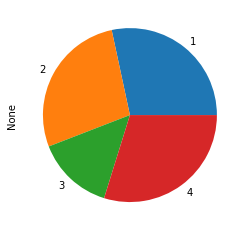

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = quarter_size.plot(kind='pie')
plt.show()

# TF-IDF를 이용해 벡터라이징

In [71]:
#df = pd.read_parquet('after_preprocessing.parquet')

source = df['source'].unique()

doc_list = df[df['source']==source[0]]['content']
doc_list

0      언니 평소 가보고 싶어 하던 휴애리 축제 다녀왔어요 지금 한참 만발 해서 꽃길 걷다...
1      안녕하세요 아델라 입니다 이번 포스팅 휴애리 자연생활공원 사진 많은 이었어요 저희 ...
2      제주도 휴애리 자연생활공원 제주 매화축제 구경 제주 서귀포시 남원읍 매일 연중 입장...
3      안녕하세요 량애 절반 지나가고 있네요 아직도 머물러 있어요 제주도 여행 다녀온지 얼...
4      서귀포 가볼만 휴애리 자연생활공원 동백 포토 진짜 제주도 가서 이렇게 동백 미친듯이...
                             ...                        
693    초여름 사실 신록 어울림 느낄 있는 시기 여전히 미세먼지 걱정 앞서긴 공기 맑은 바...
694    여행 비수기 하죠 놓치지 말아야 축제 열린다는 마지막 겨울 만끽 있는 얼음 낚시 벌...
695    아이 데리 나들이 하기 좋은 가을 맞아 선선 바람 타고 전국 축제 소식 들리네요 예...
696    언제 가도 누구 함께 해도 즐거운 제주 여행 제주도 여행 가시는 들이라면 어느 지역...
697    새해 골프 여행 인기 계속 됩니다 해외 골프여행 갈만 정말 많지만 국내 혹은 당일치...
Name: content, Length: 698, dtype: object

In [74]:

vectorizer = TfidfVectorizer(analyzer = 'word')

vectorizer.fit(doc_list)
#sorted(vectorizer.vocabulary_.items())
sorted(vectorizer.vocabulary_.items())

[('10월의제주', 0),
 ('10월제주도', 1),
 ('10월제주도여행', 2),
 ('10월제주여행', 3),
 ('1131도로', 4),
 ('12월제주여행', 5),
 ('1박2일제주', 6),
 ('1월제주감귤따기체험', 7),
 ('1월휴애리동백', 8),
 ('2019년', 9),
 ('20210618제주도', 10),
 ('2022휴애리매화축제', 11),
 ('21일차', 12),
 ('2박3일', 13),
 ('2월', 14),
 ('2월제주도', 15),
 ('2월제주도여행', 16),
 ('2월제주여행', 17),
 ('2월중순휴애리', 18),
 ('3박4일제주도여행동선', 19),
 ('4월꽃구경', 20),
 ('4일차_1', 21),
 ('5월말휴애리', 22),
 ('5월수국', 23),
 ('5월의휴애리', 24),
 ('5월제주도여행지', 25),
 ('6시내고향저희는', 26),
 ('6월의수국', 27),
 ('6월제주', 28),
 ('6월제주도', 29),
 ('6월제주도여행지', 30),
 ('8월제주도가볼만한곳', 31),
 ('hello', 32),
 ('hueree_camellia_festival휴애리', 33),
 ('jeju', 34),
 ('jmtgr', 35),
 ('kf94나', 36),
 ('nikon_d810', 37),
 ('samsung_galaxy_s10plus', 38),
 ('tamron_sp90mm', 39),
 ('tamron_sp90mm_f2_8_di_macro_vc_usd', 40),
 ('가가', 41),
 ('가거나', 42),
 ('가게', 43),
 ('가겠고', 44),
 ('가겠다고', 45),
 ('가겠어요', 46),
 ('가겠지', 47),
 ('가격', 48),
 ('가격표', 49),
 ('가고', 50),
 ('가고싶', 51),
 ('가고싶다', 52),
 ('가고싶더라구요', 53),
 ('가고싶어', 54),
 ('가고싶어서', 55),
 ('가고싶어요

In [ ]:
tokenized_doc = okt.pos(doc)
stop_word = ['있는','있고','있으니','입니다.','이렇게','있을']
#print(tokenized_doc)
tokenized_list = [w for w,t in tokenized_doc if  t not in ['Verb'] or w in stop_word]

tok_sentence = ' '.join(tokenized_list)

#n_gram_range=(2,3)

#count = CountVectorizer(ngram_range=n_gram_range).fit([tok_sentence])
#count = CountVectorizer().fit([tok_sentence]) 
candidates = vectorizer.get_feature_names()



doc_embedding = model.encode([doc])
candidate_embeddings = model.encode(candidates)


# distances = cosine_similarity(doc_embedding, candidate_embeddings)
# # argsort = sort전 index값을 반환
# keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]] 
# keywords

#mmr(doc_embedding, candidate_embeddings, candidates, top_n=10, diversity=0.5)

In [ ]:
mmr(doc_embedding, candidate_embeddings, candidates, top_n=10, diversity=0.5)